In [2]:
#importing necessary libraries.
import numpy as np
import sklearn
from sklearn import *
import pandas as pd
import matplotlib.pyplot as plt
#function to sample only positive values from a guassian.
def posOnly(fi):
    correct=False
    val=0
    while(correct==False):
        a= np.random.normal(fi,1)
        if a>0:
            val=a
            correct=True
    return val        
#function to sample only negative values from a guassian.
def negOnly(fi):
    correct=False
    val=0
    while(correct==False):
        a= np.random.normal(fi,1)
        if a<0:
            val=a
            correct=True
    return val
#function to sample v.
def sample_v(f,c):
    beta_new = (2 + 0.5*(np.dot(np.dot((f.T),np.linalg.inv(c)),(f))))
    return (1/np.random.gamma(52, (1/beta_new)))

In [3]:
#reading in the train and test data.
train= pd.read_csv("train.csv")
test= pd.read_csv("testX.csv")

In [4]:
#defining the target based on the data.
target= train["y"]
train= train.drop(columns=["y"])

In [5]:
#computing the gamma parameter to be passed into the kernel function comprising of the length scale.
Rdf =pd.concat([train,test])
trainsum=0
for i in range(1,train.shape[0]):
    trainsum+=np.linalg.norm(train[i-1:i])**2
l_sq_train = (train.shape[0]*train.shape[1])/trainsum
gammaC= (l_sq_train)**-1
testsum=0
for i in range(1,test.shape[0]):
    testsum+=np.linalg.norm(test[i-1:i])**2
l_sq_test = (test.shape[0]*test.shape[1])/testsum
gammaC_st =(l_sq_test)**-1
Rsum=0
for i in range(1,Rdf.shape[0]):
    Rsum+=np.linalg.norm(Rdf[i-1:i])**2
l_sq_R = (Rdf.shape[0]*Rdf.shape[1])/Rsum
gammaR = (l_sq_R)**-1

In [6]:
#initialising the auxialiary varaible ie z vector.
import random
z=[]
for i in target:
    if i==1:
        z.append(random.uniform(0.0001, 10))
    else:
        z.append(random.uniform(-10, -0.0001))
zvec= np.array(z)
zvec=zvec.reshape((100,1))
v= 1/np.random.gamma(2,0.5)

In [7]:
#list to store predictions for test data.
predictions=[]
#list to store z values for test data
z_stars=[]
for i in range(0,240):
    #computing the covariance matrix using rbf kernel and latest v for train, test data and train & test data points combined.
    C_star=v*sklearn.metrics.pairwise.rbf_kernel(test, Y=test, gamma=gammaC_st) + np.eye(3,3)*0.00001
    C=v*sklearn.metrics.pairwise.rbf_kernel(train, Y=train, gamma=gammaC) + np.eye(100,100)*0.00001
    R=v*sklearn.metrics.pairwise.rbf_kernel(train, Y=test,gamma=gammaR) + np.eye(100,3)*0.00001
    #compute updated covariance for P(F|z,Y)
    f_c=np.linalg.inv(np.linalg.inv(C) + np.eye(100,100))
    #computing the covariance for f_star.
    f_st_s= C_star - np.dot(np.dot(R.T,np.linalg.inv(C)),R)
    #computing the mean for P(F|z,Y)
    f_m= np.dot(f_c,zvec)
    #generate the samples for P(F|z,Y)
    f_samples=np.random.multivariate_normal(f_m.flatten(), f_c, 1).T
    for i in range(train.shape[0]):
        if target[i] == 0:
            val=negOnly(f_samples[i]) #sample from the conditional P(z_i|f_i,Y=0).
            zvec[i]=val
        else:
            val=posOnly(f_samples[i]) #sample from the conditional P(z_i|f_i,Y=1).
            zvec[i]=val
    #computing the mean for f_star
    f_st_m= np.dot(np.dot(R.T,np.linalg.inv(C)),f_samples)
    #generating samples from f_star.
    f_star_samples = np.random.multivariate_normal(f_st_m.flatten(), f_st_s, 1).T
    #generating z values from f_star.
    z_star=np.random.multivariate_normal(f_star_samples.flatten(),np.eye(3,3), 1).T
    #making predictions based on z star values.
    pred= [0 if i<0 else 1 for i in z_star]
    predictions.append(pred)
    #adding the predictions and z star values for each iteration to the list.
    z_stars.append(z_star)
    #sampling new value for v.
    v = sample_v(f_samples,C)

In [8]:
#printing predictive probabilities.
print("Predictive Probabilities for rows 1,2 and 17: ")
pd.DataFrame(predictions).mean()

Predictive Probabilities for rows 1,2 and 17: 


0    0.150000
1    0.404167
2    0.791667
dtype: float64

In [9]:
#code for generating histogram.
preds= pd.DataFrame(predictions)
zl=[list(i) for i in z_stars]
zstars= pd.DataFrame(zl)
z1=[]
for i in zstars[0]:
    for j in i:
        z1.append(float(j))
z2=[]
for i in zstars[1]:
    for j in i:
        z2.append(float(j))
z17=[]
for i in zstars[2]:
    for j in i:
        z17.append(float(j))        

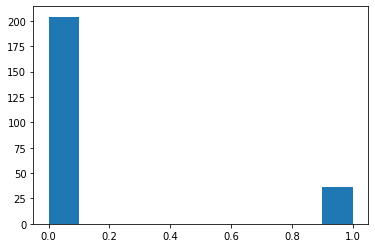

In [10]:
#predictions for row 1 histogram
plt.hist(preds[0])
plt.show()

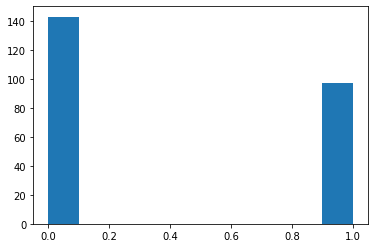

In [11]:
#predictions for row 2 histogram
plt.hist(preds[1])
plt.show()

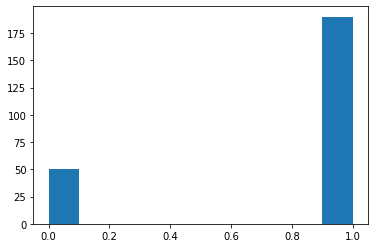

In [12]:
#predictions for row 17 histogram
plt.hist(preds[2])
plt.show()

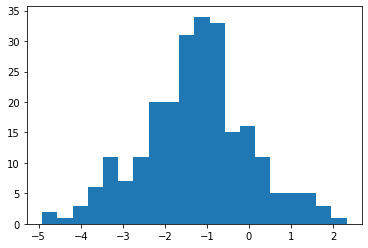

In [13]:
#z values for row 1 histogram
plt.hist(z1,bins=20)
plt.show()

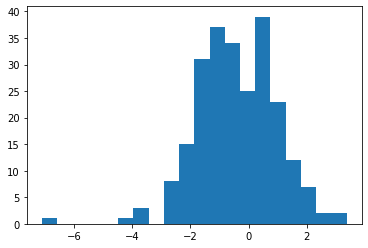

In [14]:
#z values for row 2 histogram
plt.hist(z2,bins=20)
plt.show()

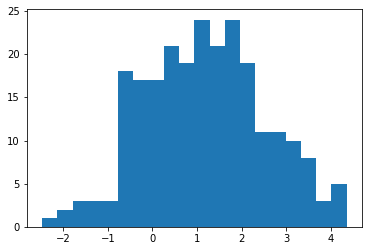

In [15]:
#z values for row 17 histogram
plt.hist(z17,bins=20)
plt.show()